In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

In [2]:
# CODE SUMMARY AND EXPLANATION: this program colors regions on a graph 2 colors such that
# no region of a given color is bordering a region of the same color. the following assumptions
# are made: 

# 1. the regions are represented as a rectangle of width X units and height y units
# where each region is a unit in the rectangle. ex if X = 3 and Y = 2 then there are 6 regions,
# consisting of 3 across and 2 down. 

# 2. the color of a region (when the region is indexed from 0) is indicated by the binary value of the
# corresponding qubit after measurement. ex: if qubit 1 has the value 1 then it is one color and if qubit 2
# has value 0 then it is the other color.

# 3. only perectly rectangular X by Y regions are considered valid. ex: a group of 7 regions where the first row
# holds 4 regions and the second row has 3 regions is not rectangular and therefore invalid as it cannot be expressed
# in terms of height and width.



x = 2 # width of rectangle
y = 2 # height of rectangle
n = x * y
var_qubits = QuantumRegister(n, name='v')
clause_qubits = QuantumRegister(n-1, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(n, name='cbits')
circuit = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

In [3]:
def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

In [4]:
def h_gates(qc, n):
    for q in range(n):
        qc.h(q)
    
    return qc

In [5]:
def diffuser(n):
    qc = QuantumCircuit(n)
    for qubit in range(n):
        qc.h(qubit)
    for qubit in range(n):
        qc.x(qubit)
    
    # multi controlled z gate
    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)
    qc.h(n-1)
    
    for qubit in range(n):
        qc.x(qubit)
    for qubit in range(n):
        qc.h(qubit)
    
    # return diffuser as gate
    D_i = qc.to_gate()
    D_i.name = "D$_i$"
    return D_i

In [6]:
def oracle(n, clause_qubits):
    var_qubits = QuantumRegister(n, name='v')
    clause_qubits = QuantumRegister(n-1, name='c')
    output_qubit = QuantumRegister(1, name='out')
    qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)
    if (x % 2 == 0): # even X
        # compute clauses
        i = 1
        while i < n:
            if (i % x != 0):
                XOR(qc, i-1, i, clause_qubits[i-1])
            else:
                XOR(qc, i-x, i, clause_qubits[i-1])
            i=i+1
        
        # flip output if all clauses satisfied
        qc.mct(clause_qubits, output_qubit)
        
        # uncompute clauses
        i = 1
        while i < n:
            if (i % x != 0):
                XOR(qc, i-1, i, clause_qubits[i-1])
            else:
                XOR(qc, i-x, i, clause_qubits[i-1])
            i=i+1
    
    else: # odd X
        # compute clauses
        i = 1
        while i < n:
            XOR(qc, i-1, i, clause_qubits[i-1])
            i=i+1
        
        # flip output if all clauses satisfied
        qc.mct(clause_qubits, output_qubit)
        
        # uncompute clauses
        i = 1
        while i < n:
            XOR(qc, i-1, i, clause_qubits[i-1])
            i=i+1
    # return oracle as gate
    O_i = qc.to_gate()
    O_i.name = "O$_i$"
    return O_i

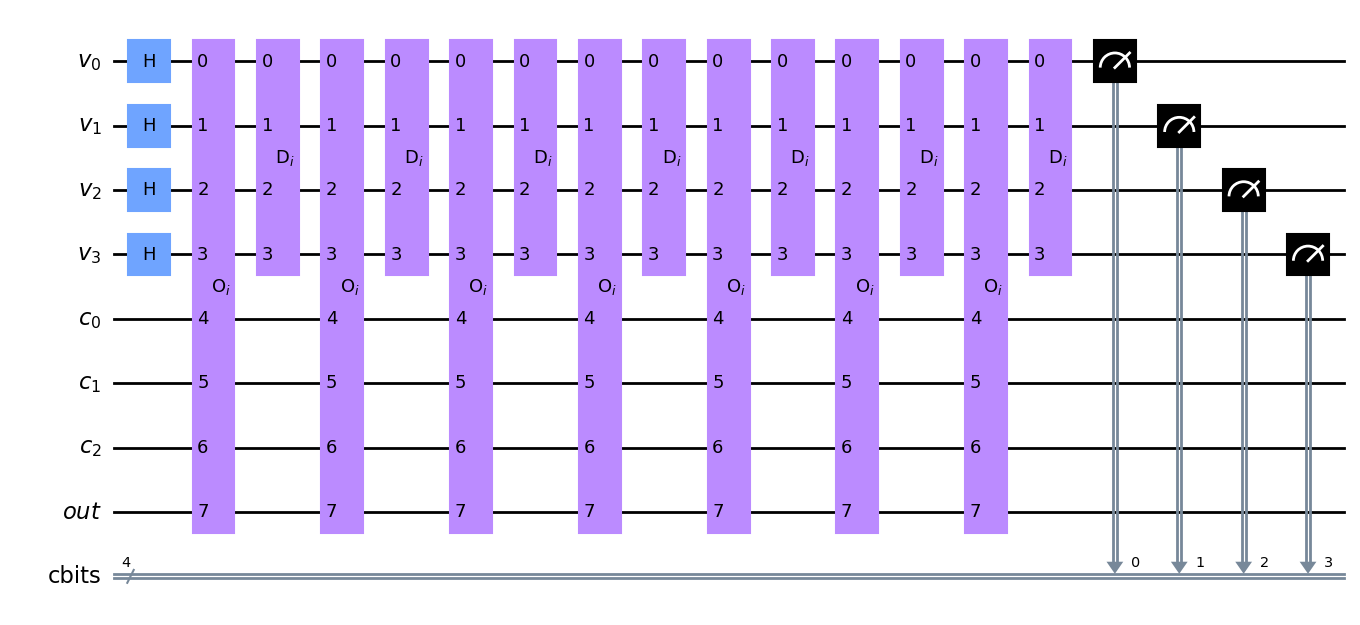

In [7]:
circuit = h_gates(circuit, n)
for i in range(int(np.ceil((2**n)**(2/3)))):
    circuit.append(oracle(n, clause_qubits), np.arange(0, 2*n, 1).tolist())
    circuit.append(diffuser(n), np.arange(0, n, 1).tolist())
circuit.measure(var_qubits, cbits)
circuit.draw()

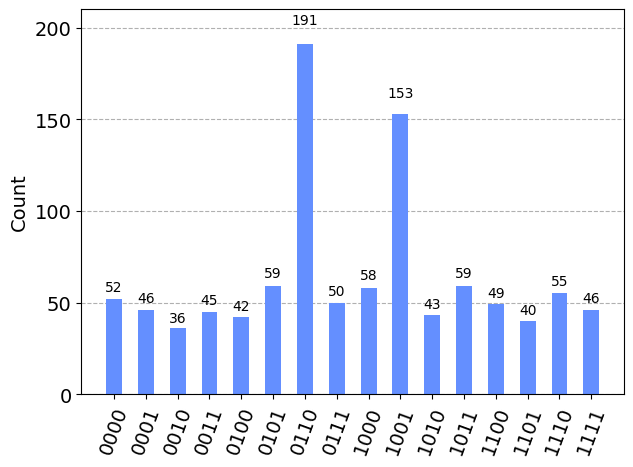

In [8]:
aer_simulator = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(circuit, aer_simulator)
result = aer_simulator.run(transpiled_qc).result()
plot_histogram(result.get_counts())